# Feature Extraction from Time Series Data Using a Neural Network

Currently not using pycbc data yet as constructing the model

TODO:
- Generate simple data -> Done
- Add noise -> Done
- Build NN model for parameter estimation --> Done
- Training loop -> Done
- Testing of trained model --> Done
- Parameter Search for best model --> Done
- Need to be able to predict multiple parameters
- Update Model to do parameter prosterior prediction, look at dingo
- Update to pycbc noise
- Update to pycbc data
- Data pre-processing
- Finished?

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import itertools
import random
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
# just generating some datasets for the time being
data_samples = 2000
mean = 10
std = 3
no_time_steps = 360

amplitudes = np.random.normal(mean, std, data_samples)
frequencies = np.random.normal(mean, std, data_samples)
parameters = np.column_stack((amplitudes, frequencies))

time_steps = np.linspace(0,120,no_time_steps)

signals = np.array([np.sin(2*np.pi*frequencies[a]*time_steps)*amplitudes[a] for a in range(0, data_samples)])

# adding noise, just gaussian for the time being
noise_mean = 0
noise_std = 0.5
noised_signals = np.array([x + np.random.normal(noise_mean, noise_std, no_time_steps) for x in signals])

signal_deriv = np.gradient(noised_signals, axis=1)
features = np.stack([noised_signals, signal_deriv], axis=2)  # -> (data_samples, no_time_steps, 2)

# convert to pytorch datasets
X = torch.FloatTensor(features)
y = torch.FloatTensor(parameters)

data = TensorDataset(X,y)

print(X)

train_data, val_data, test_data = random_split(data, lengths=[0.8,0.1,0.1])

batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)



tensor([[-0.8867,  0.6251,  0.3802,  ...,  0.6220,  1.1761,  1.3268],
        [-0.7458, -0.7330, -1.7104,  ..., -0.3669, -0.8769, -0.8319],
        [-0.3636, -0.9946,  0.7037,  ..., -0.1852,  1.1967, -0.7782],
        ...,
        [-0.0840, -0.6628,  0.9469,  ...,  0.0957,  0.6749, -1.1082],
        [-0.8781,  0.0784, -0.0381,  ..., -1.2352,  0.6975, -0.0533],
        [ 0.1693, -1.3996, -0.7984,  ...,  0.0700,  1.3193, -1.2894]])


Text(0.5, 0, 'Amplitudes')

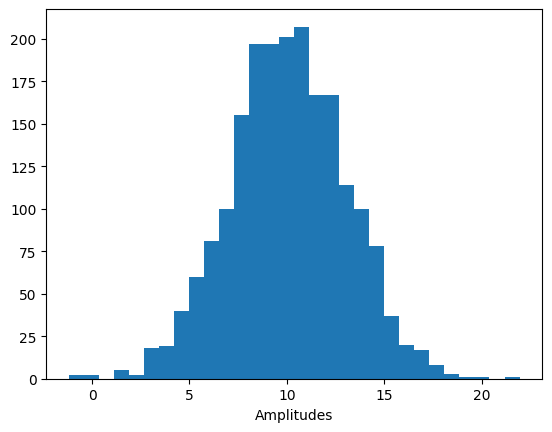

In [103]:
plt.hist(amplitudes, bins=30)
plt.xlabel("Amplitudes")

Text(0, 0.5, 'Amplitude')

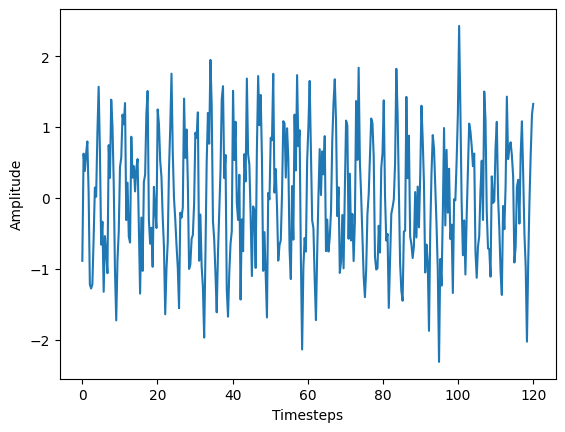

In [136]:
plt.plot(time_steps, noised_signals[0])
plt.xlabel("Timesteps")
plt.ylabel("Amplitude")

## Model

Most suggestions ive seen involve LSTM, probably worth looking into that more

In [ ]:
# This initial implimentation is all from claude AI
# Going to try and get this working a bit and understand it
# And will then update

class ParameterPredictor(nn.Module):
    def __init__(self, config=None):
        super().__init__()
        
        # Default configuration
        default_config = {
            'input_size': 2,                 # Number of features per timestep
            'lstm_hidden_size': 256,
            'lstm_num_layers': 1,
            'fc_layer_sizes': [128, 64],  # Sizes of fully connected layers before output
            'activation': 'silu',  # 'silu', 'relu', 'tanh'
            'dropout': 0.0,  # Dropout probability
        }
        
        # Merge with provided config
        if config is None:
            config = {}
        self.config = {**default_config, **config}
        
        # Build LSTM
        self.lstm = nn.LSTM(
            input_size=self.config['input_size'],
            hidden_size=self.config['lstm_hidden_size'],
            num_layers=self.config['lstm_num_layers'],
            batch_first=True,
            dropout=self.config['dropout'] if self.config['lstm_num_layers'] > 1 else 0.0,
        )
        
        # Build fully connected layers
        fc_layers = []
        input_size = self.config['lstm_hidden_size']
        
        for hidden_size in self.config['fc_layer_sizes']:
            fc_layers.append(nn.Linear(input_size, hidden_size))
            
            # Add activation
            if self.config['activation'] == 'silu':
                fc_layers.append(nn.SiLU())
            elif self.config['activation'] == 'relu':
                fc_layers.append(nn.ReLU())
            elif self.config['activation'] == 'tanh':
                fc_layers.append(nn.Tanh())
            
            # Add dropout if specified
            if self.config['dropout'] > 0:
                fc_layers.append(nn.Dropout(self.config['dropout']))
            
            input_size = hidden_size
        
        # Output layer
        fc_layers.append(nn.Linear(input_size, 2)) # Changed from 1 to 2
        
        self.fc = nn.Sequential(*fc_layers)
    
    def forward(self, x):
        
        # Reshape input to [batch, sequence, features]
        #x = x.unsqueeze(-1)  # Add feature dimension: [batch, 4000, 1]
        lstm_out, _ = self.lstm(x)
        # Use last output for prediction
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out).squeeze(-1)

# Training Loop
Updated from code I wrote for the DSML Exam

In [127]:
def train_model(model, optimizer, loss_fcn, n_epochs, train_dloader, val_dloader, start_epoch = 0, patience = 8, scheduler=None, save_best_model=False, model_path='best_model.pt'):
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    best_val_loss = float('inf')
    best_val_epoch = 0

    for epoch in range(start_epoch, start_epoch + n_epochs):
        model.train()
        tloss, vloss = 0, 0
        train_predictions = []
        train_targets = []

        for X_train, y_train in tqdm(train_dloader, desc='Epoch {}, training'.format(epoch+1)):
            optimizer.zero_grad()
            pred = model(X_train)
            loss = loss_fcn(pred, y_train) # loss = loss_fcn(pred, y_train.flatten())            
            tloss += loss.item()
            loss.backward()
            optimizer.step()
            
            train_predictions.extend(pred.detach().cpu().numpy())
            train_targets.extend(y_train.detach().cpu().numpy())

            
        model.eval()
        vloss = 0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            vtrue_preds, vcount = 0., 0
            for X_valid, y_valid in tqdm(val_dloader, desc='Epoch {}, validation'.format(epoch+1)):
                pred = model(X_valid)
                loss = loss_fcn(pred, y_valid) # loss = loss_fcn(pred, y_valid.flatten())

                vloss += loss.item()

                val_predictions.extend(pred.detach().cpu().numpy()) # val_predictions.extend(pred.numpy())
                val_targets.extend(y_valid.detach().cpu().numpy()) # val_targets.extend(y_valid.flatten().numpy())

        # Calculate metrics
        train_metrics_dict = calculate_metrics(
            np.array(train_predictions), 
            np.array(train_targets)
        )
        val_metrics_dict = calculate_metrics(
            np.array(val_predictions), 
            np.array(val_targets)
        )

        # Store losses
        avg_train_loss = tloss / len(train_dloader)
        avg_val_loss = vloss / len(val_dloader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Store metrics
        train_metrics.append(train_metrics_dict)
        val_metrics.append(val_metrics_dict)

        # Print epoch results
        print(f"\n[Epoch {epoch+1:2d}]")
        print(f"Training - Loss: {avg_train_loss:.4f}, MAE: {train_metrics_dict['mae']:.4f}, "
              f"RMSE: {train_metrics_dict['rmse']:.4f}, R²: {train_metrics_dict['r2']:.4f}")
        print(f"Validation - Loss: {avg_val_loss:.4f}, MAE: {val_metrics_dict['mae']:.4f}, "
              f"RMSE: {val_metrics_dict['rmse']:.4f}, R²: {val_metrics_dict['r2']:.4f} \n")

        # Learning rate scheduling
        if scheduler is not None:
            scheduler.step(avg_val_loss)
            current_lr = [param_group['lr'] for param_group in optimizer.param_groups]
            print(f"Current learning rates: {current_lr}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            print("New best validation performance \n")
            best_val_loss = avg_val_loss
            best_val_epoch = epoch
            
            # Save the best model
            if save_best_model:
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_loss': best_val_loss,
                    'model_config': model.config if hasattr(model, 'config') else None,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_metrics': train_metrics,
                    'val_metrics': val_metrics
                }
                torch.save(checkpoint, model_path)
                print(f"Model checkpoint saved to {model_path}\n")
                
        elif best_val_epoch <= epoch - patience:
            print(f'No improvement in validation loss in last {patience} epochs \n')
            break

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'best_val_loss': best_val_loss,
        'best_val_epoch': best_val_epoch
    }

def calculate_metrics(predictions, targets):
    """Calculate regression metrics for parameter estimation"""
    mae = np.mean(np.abs(predictions - targets))
    rmse = np.sqrt(np.mean((predictions - targets) ** 2))
    
    # R² score
    ss_res = np.sum((targets - predictions) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

def load_best_model(model_path='best_model.pt'):
    """
    Load the best saved model checkpoint.
    Returns (model, checkpoint). Falls back to allowlisting numpy scalar if needed.
    """
    try:
        # Try the safe/weights_only-friendly load first (map to CPU)
        checkpoint = torch.load(model_path, map_location='cpu')
    except Exception as e:
        # If that fails due to restricted unpickling, allowlist the numpy scalar global
        import numpy as _np
        try:
            torch.serialization.add_safe_globals([_np._core.multiarray.scalar])
        except Exception:
            # fallback name for some numpy versions
            try:
                torch.serialization.add_safe_globals([_np.core.multiarray.scalar])
            except Exception:
                pass
        # Now load with full unpickling (only for trusted files)
        checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)

    # Recreate model with saved config (handle missing config)
    model_config = checkpoint.get('model_config', None)
    model = ParameterPredictor(model_config if model_config is not None else None)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"Loaded model from {model_path}")
    if 'epoch' in checkpoint:
        print(f"  Best epoch: {checkpoint['epoch'] + 1}")
    if 'best_val_loss' in checkpoint:
        print(f"  Best validation loss: {checkpoint['best_val_loss']:.4f}")

    return model, checkpoint

In [107]:
# model = ParameterPredictor()
# lossfcn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.5,
#     patience=3,
#     min_lr=1e-6,
#     verbose=True
# )

# outputs = train_model(model, optimizer, lossfcn, 50, train_loader, val_loader, scheduler=scheduler)

In [108]:
# plt.plot(outputs['train_losses'], label='Train Loss')
# plt.plot(outputs['val_losses'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


# Hyperparameter Search

In [109]:
def hyperparameter_search(param_grid, train_loader, val_loader, n_epochs=20, n_trials=None):
    """
    Search for the best hyperparameter configuration.
    
    Args:
        param_grid: Dictionary of parameter names to lists of values to try
        train_loader: Training data loader
        val_loader: Validation data loader
        n_epochs: Number of epochs to train each configuration
        n_trials: Number of random configurations to try (None = try all combinations)
    
    Returns:
        best_config: Dictionary with the best configuration
        results: List of dictionaries with all trial results
    """

    
    results = []
    best_val_loss = float('inf')
    best_config = None
    
    # Generate all combinations or sample randomly
    param_names = list(param_grid.keys())
    param_values = [param_grid[name] for name in param_names]
    
    if n_trials is None:
        # Try all combinations (grid search)
        all_combinations = list(itertools.product(*param_values))
    else:
        # Random search: sample n_trials random combinations
        all_combinations = []
        for _ in range(n_trials):
            combo = tuple(random.choice(values) for values in param_values)
            all_combinations.append(combo)
    
    print(f"Testing {len(all_combinations)} configurations...\n")
    
    for i, combo in enumerate(all_combinations):
        # Create config dictionary
        config = dict(zip(param_names, combo))
        
        print(f"{'='*60}")
        print(f"Trial {i+1}/{len(all_combinations)}")
        print(f"Config: {config}")
        print(f"{'='*60}")
        
        # Create model with this configuration
        model = ParameterPredictor(config)
        
        # Create optimizer and scheduler
        lr = config.get('learning_rate', 0.01)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            min_lr=1e-6,
            #verbose=False  # Less verbose during search
        )
        
        loss_fcn = nn.MSELoss()
        
        # Train the model
        try:
            outputs = train_model(
                model, 
                optimizer, 
                loss_fcn, 
                n_epochs, 
                train_loader, 
                val_loader, 
                patience=8,
                scheduler=scheduler
            )
            
            # Get best validation loss
            final_val_loss = min(outputs['val_losses'])
            final_val_metrics = outputs['val_metrics'][outputs['val_losses'].index(final_val_loss)]
            
            # Store results
            result = {
                'config': config.copy(),
                'best_val_loss': final_val_loss,
                'best_val_mae': final_val_metrics['mae'],
                'best_val_rmse': final_val_metrics['rmse'],
                'best_val_r2': final_val_metrics['r2'],
                'n_epochs_trained': len(outputs['val_losses'])
            }
            results.append(result)
            
            print(f"\nFinal validation loss: {final_val_loss:.4f}")
            print(f"Best validation R²: {final_val_metrics['r2']:.4f}\n")
            
            # Update best configuration
            if final_val_loss < best_val_loss:
                best_val_loss = final_val_loss
                best_config = config.copy()
                print(f"*** New best configuration found! ***\n")
        
        except Exception as e:
            print(f"Error training with config {config}: {e}\n")
            continue
    
    # Print summary
    print(f"\n{'='*60}")
    print("HYPERPARAMETER SEARCH COMPLETE")
    print(f"{'='*60}")
    print(f"\nBest configuration:")
    #for key, value in best_config.items():
    #    print(f"  {key}: {value}")
    #print(f"\nBest validation loss: {best_val_loss:.4f}")
    
    # Sort results by validation loss
    results.sort(key=lambda x: x['best_val_loss'])
    
    return best_config, results



Security note
- Only use the allowlist + weights_only=False fallback for checkpoints you trust.

In [118]:
# Define the hyperparameter grid
param_grid = {
    'lstm_hidden_size': [128, 256],
    'lstm_num_layers': [1],
    'fc_layer_sizes': [[128, 64], [256, 128], [64, 32]],
    'activation': ['relu'],
    'dropout': [0.0],
    'learning_rate': [0.01]
}

# Run hyperparameter search
# Use n_trials for random search (faster) or set to None for full grid search
best_config, search_results = hyperparameter_search(
    param_grid, 
    train_loader, 
    val_loader, 
    n_epochs=50,
    n_trials=None  # Try 10 random configurations (set to None to try all combinations)
)

# Display top 5 configurations
print("\nTop 5 configurations:")
for i, result in enumerate(search_results[:5]):
    print(f"\n{i+1}. Val Loss: {result['best_val_loss']:.4f}, R²: {result['best_val_r2']:.4f}")
    print(f"   Config: {result['config']}")

Testing 6 configurations...

Trial 1/6
Config: {'lstm_hidden_size': 128, 'lstm_num_layers': 1, 'fc_layer_sizes': [128, 64], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}


Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 91.52it/s]



[Epoch  1]
Training - Loss: 15.8794, MAE: 3.0439, RMSE: 3.9849, R²: -0.7606
Validation - Loss: 9.6180, MAE: 2.3732, RMSE: 3.0703, R²: -0.0621 

Current learning rates: [0.01]
New best validation performance 



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 112.42it/s]



[Epoch  2]
Training - Loss: 8.4842, MAE: 2.3286, RMSE: 2.9128, R²: 0.0593
Validation - Loss: 7.7263, MAE: 2.1055, RMSE: 2.7431, R²: 0.1522 

Current learning rates: [0.01]
New best validation performance 



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 75.69it/s]



[Epoch  3]
Training - Loss: 7.7228, MAE: 2.1769, RMSE: 2.7790, R²: 0.1438
Validation - Loss: 9.3808, MAE: 2.4661, RMSE: 3.0249, R²: -0.0309 

Current learning rates: [0.01]


Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 110.62it/s]



[Epoch  4]
Training - Loss: 6.9452, MAE: 2.0155, RMSE: 2.6354, R²: 0.2300
Validation - Loss: 6.1347, MAE: 1.7099, RMSE: 2.4278, R²: 0.3359 

Current learning rates: [0.01]
New best validation performance 



Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 108.14it/s]



[Epoch  5]
Training - Loss: 6.4850, MAE: 1.9285, RMSE: 2.5466, R²: 0.2810
Validation - Loss: 5.5297, MAE: 1.6336, RMSE: 2.3140, R²: 0.3967 

Current learning rates: [0.01]
New best validation performance 



Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 112.70it/s]



[Epoch  6]
Training - Loss: 5.5945, MAE: 1.7071, RMSE: 2.3653, R²: 0.3797
Validation - Loss: 5.2381, MAE: 1.5304, RMSE: 2.2783, R²: 0.4152 

Current learning rates: [0.01]
New best validation performance 



Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 111.37it/s]



[Epoch  7]
Training - Loss: 5.8463, MAE: 1.7611, RMSE: 2.4179, R²: 0.3518
Validation - Loss: 5.7126, MAE: 1.6521, RMSE: 2.3638, R²: 0.3704 

Current learning rates: [0.01]


Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 104.14it/s]



[Epoch  8]
Training - Loss: 5.4076, MAE: 1.6684, RMSE: 2.3254, R²: 0.4005
Validation - Loss: 4.9624, MAE: 1.4772, RMSE: 2.1984, R²: 0.4555 

Current learning rates: [0.01]
New best validation performance 



Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 94.79it/s]



[Epoch  9]
Training - Loss: 5.5350, MAE: 1.6744, RMSE: 2.3527, R²: 0.3863
Validation - Loss: 5.0981, MAE: 1.4622, RMSE: 2.2207, R²: 0.4444 

Current learning rates: [0.01]


Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 99.31it/s]



[Epoch 10]
Training - Loss: 5.4183, MAE: 1.6297, RMSE: 2.3277, R²: 0.3993
Validation - Loss: 4.9481, MAE: 1.4495, RMSE: 2.2059, R²: 0.4517 

Current learning rates: [0.01]
New best validation performance 



Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 102.02it/s]



[Epoch 11]
Training - Loss: 4.9010, MAE: 1.4812, RMSE: 2.2138, R²: 0.4566
Validation - Loss: 5.5564, MAE: 1.5495, RMSE: 2.3591, R²: 0.3730 

Current learning rates: [0.01]


Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 102.69it/s]



[Epoch 12]
Training - Loss: 5.0832, MAE: 1.5031, RMSE: 2.2546, R²: 0.4364
Validation - Loss: 5.0605, MAE: 1.4438, RMSE: 2.2111, R²: 0.4492 

Current learning rates: [0.01]


Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 101.14it/s]



[Epoch 13]
Training - Loss: 5.0756, MAE: 1.5296, RMSE: 2.2529, R²: 0.4373
Validation - Loss: 5.2006, MAE: 1.6468, RMSE: 2.2667, R²: 0.4211 

Current learning rates: [0.005]


Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 92.66it/s]



[Epoch 14]
Training - Loss: 4.8254, MAE: 1.4418, RMSE: 2.1967, R²: 0.4650
Validation - Loss: 4.9237, MAE: 1.3469, RMSE: 2.1807, R²: 0.4642 

Current learning rates: [0.005]
New best validation performance 



Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 87.11it/s]



[Epoch 15]
Training - Loss: 4.8482, MAE: 1.4240, RMSE: 2.2019, R²: 0.4625
Validation - Loss: 4.9008, MAE: 1.4873, RMSE: 2.1920, R²: 0.4586 

Current learning rates: [0.005]
New best validation performance 



Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 93.56it/s]



[Epoch 16]
Training - Loss: 4.8329, MAE: 1.4662, RMSE: 2.1984, R²: 0.4642
Validation - Loss: 4.9559, MAE: 1.3476, RMSE: 2.2196, R²: 0.4449 

Current learning rates: [0.005]


Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 99.46it/s]



[Epoch 17]
Training - Loss: 4.7317, MAE: 1.4018, RMSE: 2.1752, R²: 0.4754
Validation - Loss: 4.9564, MAE: 1.3586, RMSE: 2.2172, R²: 0.4461 

Current learning rates: [0.005]


Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 101.56it/s]



[Epoch 18]
Training - Loss: 4.8499, MAE: 1.4292, RMSE: 2.2023, R²: 0.4623
Validation - Loss: 5.1362, MAE: 1.4145, RMSE: 2.2192, R²: 0.4451 

Current learning rates: [0.0025]


Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 89.40it/s]



[Epoch 19]
Training - Loss: 4.6490, MAE: 1.3468, RMSE: 2.1561, R²: 0.4846
Validation - Loss: 4.7094, MAE: 1.3404, RMSE: 2.1468, R²: 0.4807 

Current learning rates: [0.0025]
New best validation performance 



Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 82.82it/s]



[Epoch 20]
Training - Loss: 4.6569, MAE: 1.3573, RMSE: 2.1580, R²: 0.4837
Validation - Loss: 4.7575, MAE: 1.3637, RMSE: 2.1651, R²: 0.4719 

Current learning rates: [0.0025]


Epoch 21, validation: 100%|██████████| 13/13 [00:00<00:00, 89.61it/s]



[Epoch 21]
Training - Loss: 4.6806, MAE: 1.3663, RMSE: 2.1635, R²: 0.4811
Validation - Loss: 4.8259, MAE: 1.4342, RMSE: 2.1784, R²: 0.4653 

Current learning rates: [0.0025]


Epoch 22, validation: 100%|██████████| 13/13 [00:00<00:00, 98.47it/s]



[Epoch 22]
Training - Loss: 4.6595, MAE: 1.3460, RMSE: 2.1586, R²: 0.4834
Validation - Loss: 4.7109, MAE: 1.2944, RMSE: 2.1524, R²: 0.4781 

Current learning rates: [0.00125]


Epoch 23, validation: 100%|██████████| 13/13 [00:00<00:00, 95.86it/s]



[Epoch 23]
Training - Loss: 4.5534, MAE: 1.2997, RMSE: 2.1339, R²: 0.4952
Validation - Loss: 4.7094, MAE: 1.2797, RMSE: 2.1533, R²: 0.4776 

Current learning rates: [0.00125]


Epoch 24, validation: 100%|██████████| 13/13 [00:00<00:00, 103.59it/s]



[Epoch 24]
Training - Loss: 4.5670, MAE: 1.3124, RMSE: 2.1370, R²: 0.4937
Validation - Loss: 4.6759, MAE: 1.2863, RMSE: 2.1414, R²: 0.4833 

Current learning rates: [0.00125]
New best validation performance 



Epoch 25, validation: 100%|██████████| 13/13 [00:00<00:00, 97.36it/s]



[Epoch 25]
Training - Loss: 4.5336, MAE: 1.3049, RMSE: 2.1292, R²: 0.4974
Validation - Loss: 4.9448, MAE: 1.3201, RMSE: 2.2165, R²: 0.4465 

Current learning rates: [0.00125]


Epoch 26, validation: 100%|██████████| 13/13 [00:00<00:00, 97.57it/s]



[Epoch 26]
Training - Loss: 4.5915, MAE: 1.3187, RMSE: 2.1428, R²: 0.4909
Validation - Loss: 4.7458, MAE: 1.2935, RMSE: 2.1485, R²: 0.4799 

Current learning rates: [0.00125]


Epoch 27, validation: 100%|██████████| 13/13 [00:00<00:00, 103.66it/s]



[Epoch 27]
Training - Loss: 4.5460, MAE: 1.3115, RMSE: 2.1321, R²: 0.4960
Validation - Loss: 4.6980, MAE: 1.3077, RMSE: 2.1478, R²: 0.4802 

Current learning rates: [0.000625]


Epoch 28, validation: 100%|██████████| 13/13 [00:00<00:00, 102.04it/s]



[Epoch 28]
Training - Loss: 4.5113, MAE: 1.2916, RMSE: 2.1240, R²: 0.4998
Validation - Loss: 4.7005, MAE: 1.2835, RMSE: 2.1509, R²: 0.4788 

Current learning rates: [0.000625]


Epoch 29, validation: 100%|██████████| 13/13 [00:00<00:00, 100.59it/s]



[Epoch 29]
Training - Loss: 4.5223, MAE: 1.2863, RMSE: 2.1266, R²: 0.4986
Validation - Loss: 4.7139, MAE: 1.3259, RMSE: 2.1525, R²: 0.4780 

Current learning rates: [0.000625]


Epoch 30, validation: 100%|██████████| 13/13 [00:00<00:00, 102.50it/s]



[Epoch 30]
Training - Loss: 4.5412, MAE: 1.3051, RMSE: 2.1310, R²: 0.4965
Validation - Loss: 4.7254, MAE: 1.2970, RMSE: 2.1463, R²: 0.4810 

Current learning rates: [0.0003125]


Epoch 31, validation: 100%|██████████| 13/13 [00:00<00:00, 98.81it/s]



[Epoch 31]
Training - Loss: 4.5013, MAE: 1.2772, RMSE: 2.1216, R²: 0.5009
Validation - Loss: 4.6795, MAE: 1.2876, RMSE: 2.1403, R²: 0.4839 

Current learning rates: [0.0003125]


Epoch 32, validation: 100%|██████████| 13/13 [00:00<00:00, 95.64it/s]



[Epoch 32]
Training - Loss: 4.4991, MAE: 1.2804, RMSE: 2.1211, R²: 0.5012
Validation - Loss: 4.6770, MAE: 1.2853, RMSE: 2.1411, R²: 0.4835 

Current learning rates: [0.0003125]
No improvement in validation loss in last 8 epochs 


Final validation loss: 4.6759
Best validation R²: 0.4833

*** New best configuration found! ***

Trial 2/6
Config: {'lstm_hidden_size': 128, 'lstm_num_layers': 1, 'fc_layer_sizes': [256, 128], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}


Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 96.36it/s]



[Epoch  1]
Training - Loss: 17.2173, MAE: 3.0292, RMSE: 4.1494, R²: -0.9089
Validation - Loss: 7.5061, MAE: 2.0719, RMSE: 2.6894, R²: 0.1851 

Current learning rates: [0.01]
New best validation performance 



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 100.52it/s]



[Epoch  2]
Training - Loss: 7.1107, MAE: 2.0601, RMSE: 2.6666, R²: 0.2116
Validation - Loss: 6.5587, MAE: 2.0224, RMSE: 2.5464, R²: 0.2694 

Current learning rates: [0.01]
New best validation performance 



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 98.90it/s]



[Epoch  3]
Training - Loss: 6.0132, MAE: 1.7949, RMSE: 2.4522, R²: 0.3333
Validation - Loss: 5.6822, MAE: 1.7217, RMSE: 2.3556, R²: 0.3748 

Current learning rates: [0.01]
New best validation performance 



Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 101.22it/s]



[Epoch  4]
Training - Loss: 5.3361, MAE: 1.6225, RMSE: 2.3100, R²: 0.4084
Validation - Loss: 5.7354, MAE: 1.8056, RMSE: 2.3511, R²: 0.3772 

Current learning rates: [0.01]


Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 93.03it/s]



[Epoch  5]
Training - Loss: 5.2063, MAE: 1.5586, RMSE: 2.2817, R²: 0.4228
Validation - Loss: 5.4209, MAE: 1.4897, RMSE: 2.2892, R²: 0.4096 

Current learning rates: [0.01]
New best validation performance 



Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 90.47it/s]



[Epoch  6]
Training - Loss: 5.0864, MAE: 1.5125, RMSE: 2.2553, R²: 0.4361
Validation - Loss: 4.9172, MAE: 1.4797, RMSE: 2.1982, R²: 0.4556 

Current learning rates: [0.01]
New best validation performance 



Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 112.10it/s]



[Epoch  7]
Training - Loss: 5.0916, MAE: 1.5214, RMSE: 2.2565, R²: 0.4355
Validation - Loss: 5.4172, MAE: 1.7538, RMSE: 2.3003, R²: 0.4038 

Current learning rates: [0.01]


Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 106.61it/s]



[Epoch  8]
Training - Loss: 5.0498, MAE: 1.5019, RMSE: 2.2472, R²: 0.4401
Validation - Loss: 5.9072, MAE: 1.5115, RMSE: 2.4293, R²: 0.3351 

Current learning rates: [0.01]


Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 104.50it/s]



[Epoch  9]
Training - Loss: 5.0397, MAE: 1.5238, RMSE: 2.2449, R²: 0.4412
Validation - Loss: 5.1770, MAE: 1.5970, RMSE: 2.2671, R²: 0.4209 

Current learning rates: [0.005]


Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 101.26it/s]



[Epoch 10]
Training - Loss: 4.7608, MAE: 1.4089, RMSE: 2.1819, R²: 0.4722
Validation - Loss: 5.0708, MAE: 1.4419, RMSE: 2.2335, R²: 0.4380 

Current learning rates: [0.005]


Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 91.58it/s] 



[Epoch 11]
Training - Loss: 4.7896, MAE: 1.4155, RMSE: 2.1885, R²: 0.4690
Validation - Loss: 5.1606, MAE: 1.5142, RMSE: 2.2642, R²: 0.4224 

Current learning rates: [0.005]


Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 98.45it/s]



[Epoch 12]
Training - Loss: 4.8670, MAE: 1.4611, RMSE: 2.2061, R²: 0.4604
Validation - Loss: 4.8344, MAE: 1.3879, RMSE: 2.1645, R²: 0.4722 

Current learning rates: [0.005]
New best validation performance 



Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 102.17it/s]



[Epoch 13]
Training - Loss: 4.6527, MAE: 1.3559, RMSE: 2.1570, R²: 0.4842
Validation - Loss: 4.8056, MAE: 1.3871, RMSE: 2.1669, R²: 0.4710 

Current learning rates: [0.005]
New best validation performance 



Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 116.61it/s]



[Epoch 14]
Training - Loss: 4.7172, MAE: 1.3778, RMSE: 2.1719, R²: 0.4770
Validation - Loss: 4.9172, MAE: 1.3946, RMSE: 2.2123, R²: 0.4486 

Current learning rates: [0.005]


Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 110.42it/s]



[Epoch 15]
Training - Loss: 4.9125, MAE: 1.4714, RMSE: 2.2164, R²: 0.4553
Validation - Loss: 5.0317, MAE: 1.3694, RMSE: 2.2341, R²: 0.4376 

Current learning rates: [0.005]


Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 91.19it/s]



[Epoch 16]
Training - Loss: 4.8143, MAE: 1.4255, RMSE: 2.1941, R²: 0.4662
Validation - Loss: 4.9072, MAE: 1.3703, RMSE: 2.1839, R²: 0.4626 

Current learning rates: [0.0025]


Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 114.21it/s]



[Epoch 17]
Training - Loss: 4.6536, MAE: 1.3745, RMSE: 2.1572, R²: 0.4841
Validation - Loss: 4.7651, MAE: 1.4148, RMSE: 2.1618, R²: 0.4735 

Current learning rates: [0.0025]
New best validation performance 



Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 116.20it/s]



[Epoch 18]
Training - Loss: 4.6799, MAE: 1.3714, RMSE: 2.1633, R²: 0.4811
Validation - Loss: 4.6923, MAE: 1.2997, RMSE: 2.1428, R²: 0.4827 

Current learning rates: [0.0025]
New best validation performance 



Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 105.49it/s]



[Epoch 19]
Training - Loss: 4.6321, MAE: 1.3640, RMSE: 2.1522, R²: 0.4864
Validation - Loss: 4.8171, MAE: 1.4067, RMSE: 2.1769, R²: 0.4661 

Current learning rates: [0.0025]


Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 112.16it/s]



[Epoch 20]
Training - Loss: 4.5265, MAE: 1.3219, RMSE: 2.1276, R²: 0.4981
Validation - Loss: 4.7479, MAE: 1.3184, RMSE: 2.1487, R²: 0.4798 

Current learning rates: [0.0025]


Epoch 21, validation: 100%|██████████| 13/13 [00:00<00:00, 116.54it/s]



[Epoch 21]
Training - Loss: 4.6088, MAE: 1.3455, RMSE: 2.1468, R²: 0.4890
Validation - Loss: 4.7856, MAE: 1.3157, RMSE: 2.1647, R²: 0.4720 

Current learning rates: [0.00125]


Epoch 22, validation: 100%|██████████| 13/13 [00:00<00:00, 105.51it/s]



[Epoch 22]
Training - Loss: 4.4998, MAE: 1.3180, RMSE: 2.1213, R²: 0.5011
Validation - Loss: 4.7874, MAE: 1.3659, RMSE: 2.1573, R²: 0.4757 

Current learning rates: [0.00125]


Epoch 23, validation: 100%|██████████| 13/13 [00:00<00:00, 112.26it/s]



[Epoch 23]
Training - Loss: 4.5039, MAE: 1.3217, RMSE: 2.1222, R²: 0.5007
Validation - Loss: 4.8326, MAE: 1.3180, RMSE: 2.1790, R²: 0.4651 

Current learning rates: [0.00125]


Epoch 24, validation: 100%|██████████| 13/13 [00:00<00:00, 115.09it/s]



[Epoch 24]
Training - Loss: 4.4826, MAE: 1.2994, RMSE: 2.1172, R²: 0.5030
Validation - Loss: 4.8204, MAE: 1.3756, RMSE: 2.1666, R²: 0.4711 

Current learning rates: [0.000625]


Epoch 25, validation: 100%|██████████| 13/13 [00:00<00:00, 117.60it/s]



[Epoch 25]
Training - Loss: 4.4221, MAE: 1.2804, RMSE: 2.1029, R²: 0.5097
Validation - Loss: 4.8015, MAE: 1.3214, RMSE: 2.1701, R²: 0.4694 

Current learning rates: [0.000625]


Epoch 26, validation: 100%|██████████| 13/13 [00:00<00:00, 115.85it/s]



[Epoch 26]
Training - Loss: 4.3763, MAE: 1.2727, RMSE: 2.0920, R²: 0.5148
Validation - Loss: 4.7762, MAE: 1.3152, RMSE: 2.1586, R²: 0.4750 

Current learning rates: [0.000625]
No improvement in validation loss in last 8 epochs 


Final validation loss: 4.6923
Best validation R²: 0.4827

Trial 3/6
Config: {'lstm_hidden_size': 128, 'lstm_num_layers': 1, 'fc_layer_sizes': [64, 32], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}


Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 53.68it/s]



[Epoch  1]
Training - Loss: 15.7723, MAE: 3.0349, RMSE: 3.9714, R²: -0.7487
Validation - Loss: 9.6185, MAE: 2.3933, RMSE: 3.0777, R²: -0.0672 

Current learning rates: [0.01]
New best validation performance 



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 96.43it/s]



[Epoch  2]
Training - Loss: 9.6808, MAE: 2.4947, RMSE: 3.1114, R²: -0.0733
Validation - Loss: 9.0461, MAE: 2.3308, RMSE: 2.9711, R²: 0.0054 

Current learning rates: [0.01]
New best validation performance 



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 97.26it/s]



[Epoch  3]
Training - Loss: 9.2527, MAE: 2.4432, RMSE: 3.0418, R²: -0.0258
Validation - Loss: 10.1426, MAE: 2.4636, RMSE: 3.1428, R²: -0.1129 

Current learning rates: [0.01]


Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 116.23it/s]



[Epoch  4]
Training - Loss: 9.0766, MAE: 2.4088, RMSE: 3.0127, R²: -0.0063
Validation - Loss: 9.1347, MAE: 2.3365, RMSE: 2.9878, R²: -0.0058 

Current learning rates: [0.01]


Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 115.81it/s]



[Epoch  5]
Training - Loss: 8.9333, MAE: 2.3914, RMSE: 2.9889, R²: 0.0096
Validation - Loss: 8.8880, MAE: 2.3032, RMSE: 2.9397, R²: 0.0264 

Current learning rates: [0.01]
New best validation performance 



Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 117.38it/s]



[Epoch  6]
Training - Loss: 8.7687, MAE: 2.3604, RMSE: 2.9612, R²: 0.0278
Validation - Loss: 8.8768, MAE: 2.2928, RMSE: 2.9362, R²: 0.0287 

Current learning rates: [0.01]
New best validation performance 



Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 118.73it/s]



[Epoch  7]
Training - Loss: 8.7287, MAE: 2.3499, RMSE: 2.9544, R²: 0.0322
Validation - Loss: 8.2505, MAE: 2.2054, RMSE: 2.8384, R²: 0.0923 

Current learning rates: [0.01]
New best validation performance 



Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 123.49it/s]



[Epoch  8]
Training - Loss: 8.6050, MAE: 2.3364, RMSE: 2.9334, R²: 0.0460
Validation - Loss: 8.3575, MAE: 2.2094, RMSE: 2.8549, R²: 0.0817 

Current learning rates: [0.01]


Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 121.94it/s]



[Epoch  9]
Training - Loss: 8.5479, MAE: 2.3240, RMSE: 2.9237, R²: 0.0523
Validation - Loss: 8.0568, MAE: 2.1815, RMSE: 2.7981, R²: 0.1179 

Current learning rates: [0.01]
New best validation performance 



Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 121.64it/s]



[Epoch 10]
Training - Loss: 8.0190, MAE: 2.2372, RMSE: 2.8318, R²: 0.1109
Validation - Loss: 8.9249, MAE: 2.3582, RMSE: 2.9327, R²: 0.0310 

Current learning rates: [0.01]


Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 83.28it/s]



[Epoch 11]
Training - Loss: 7.7034, MAE: 2.1769, RMSE: 2.7755, R²: 0.1459
Validation - Loss: 6.9140, MAE: 1.9814, RMSE: 2.6031, R²: 0.2365 

Current learning rates: [0.01]
New best validation performance 



Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 118.46it/s]



[Epoch 12]
Training - Loss: 7.0042, MAE: 2.0395, RMSE: 2.6465, R²: 0.2234
Validation - Loss: 6.8559, MAE: 2.0404, RMSE: 2.5947, R²: 0.2415 

Current learning rates: [0.01]
New best validation performance 



Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 117.30it/s]



[Epoch 13]
Training - Loss: 7.2362, MAE: 2.0792, RMSE: 2.6900, R²: 0.1977
Validation - Loss: 6.8884, MAE: 1.9643, RMSE: 2.5918, R²: 0.2432 

Current learning rates: [0.01]


Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 118.28it/s]



[Epoch 14]
Training - Loss: 6.7471, MAE: 1.9907, RMSE: 2.5975, R²: 0.2519
Validation - Loss: 7.2377, MAE: 2.0437, RMSE: 2.6337, R²: 0.2185 

Current learning rates: [0.01]


Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 119.97it/s]



[Epoch 15]
Training - Loss: 6.6692, MAE: 1.9428, RMSE: 2.5825, R²: 0.2606
Validation - Loss: 6.8417, MAE: 1.9187, RMSE: 2.5811, R²: 0.2494 

Current learning rates: [0.01]
New best validation performance 



Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 120.64it/s]



[Epoch 16]
Training - Loss: 6.7747, MAE: 1.9925, RMSE: 2.6028, R²: 0.2489
Validation - Loss: 6.9499, MAE: 2.0201, RMSE: 2.6191, R²: 0.2271 

Current learning rates: [0.01]


Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 96.76it/s] 



[Epoch 17]
Training - Loss: 6.5758, MAE: 1.9569, RMSE: 2.5643, R²: 0.2709
Validation - Loss: 6.4653, MAE: 1.9011, RMSE: 2.5086, R²: 0.2910 

Current learning rates: [0.01]
New best validation performance 



Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 115.94it/s]



[Epoch 18]
Training - Loss: 6.5462, MAE: 1.9343, RMSE: 2.5586, R²: 0.2742
Validation - Loss: 5.8767, MAE: 1.7602, RMSE: 2.3859, R²: 0.3587 

Current learning rates: [0.01]
New best validation performance 



Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 110.95it/s]



[Epoch 19]
Training - Loss: 6.6239, MAE: 1.9550, RMSE: 2.5737, R²: 0.2656
Validation - Loss: 8.0688, MAE: 2.2931, RMSE: 2.7893, R²: 0.1234 

Current learning rates: [0.01]


Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 115.15it/s]



[Epoch 20]
Training - Loss: 6.9110, MAE: 2.0211, RMSE: 2.6289, R²: 0.2338
Validation - Loss: 6.9062, MAE: 1.9564, RMSE: 2.5891, R²: 0.2448 

Current learning rates: [0.01]


Epoch 21, validation: 100%|██████████| 13/13 [00:00<00:00, 106.53it/s]



[Epoch 21]
Training - Loss: 6.4763, MAE: 1.9142, RMSE: 2.5449, R²: 0.2820
Validation - Loss: 7.9438, MAE: 2.2572, RMSE: 2.7750, R²: 0.1324 

Current learning rates: [0.005]


Epoch 22, validation: 100%|██████████| 13/13 [00:00<00:00, 116.67it/s]



[Epoch 22]
Training - Loss: 6.2793, MAE: 1.8825, RMSE: 2.5059, R²: 0.3038
Validation - Loss: 6.1595, MAE: 1.8252, RMSE: 2.4472, R²: 0.3253 

Current learning rates: [0.005]


Epoch 23, validation: 100%|██████████| 13/13 [00:00<00:00, 114.01it/s]



[Epoch 23]
Training - Loss: 5.8669, MAE: 1.8111, RMSE: 2.4222, R²: 0.3495
Validation - Loss: 5.9686, MAE: 1.7919, RMSE: 2.4090, R²: 0.3462 

Current learning rates: [0.005]


Epoch 24, validation: 100%|██████████| 13/13 [00:00<00:00, 103.12it/s]



[Epoch 24]
Training - Loss: 6.1784, MAE: 1.8732, RMSE: 2.4856, R²: 0.3150
Validation - Loss: 6.5048, MAE: 1.8456, RMSE: 2.5063, R²: 0.2923 

Current learning rates: [0.0025]


Epoch 25, validation: 100%|██████████| 13/13 [00:00<00:00, 118.46it/s]



[Epoch 25]
Training - Loss: 5.7787, MAE: 1.7567, RMSE: 2.4039, R²: 0.3593
Validation - Loss: 6.1904, MAE: 1.8252, RMSE: 2.4722, R²: 0.3114 

Current learning rates: [0.0025]


Epoch 26, validation: 100%|██████████| 13/13 [00:00<00:00, 100.85it/s]



[Epoch 26]
Training - Loss: 5.7386, MAE: 1.7596, RMSE: 2.3955, R²: 0.3638
Validation - Loss: 5.6412, MAE: 1.7149, RMSE: 2.3526, R²: 0.3764 

Current learning rates: [0.0025]
New best validation performance 



Epoch 27, validation: 100%|██████████| 13/13 [00:00<00:00, 115.35it/s]



[Epoch 27]
Training - Loss: 5.5147, MAE: 1.6851, RMSE: 2.3483, R²: 0.3886
Validation - Loss: 5.4325, MAE: 1.6136, RMSE: 2.3102, R²: 0.3987 

Current learning rates: [0.0025]
New best validation performance 



Epoch 28, validation: 100%|██████████| 13/13 [00:00<00:00, 116.81it/s]



[Epoch 28]
Training - Loss: 5.6029, MAE: 1.7015, RMSE: 2.3671, R²: 0.3788
Validation - Loss: 5.7890, MAE: 1.7306, RMSE: 2.3778, R²: 0.3630 

Current learning rates: [0.0025]


Epoch 29, validation: 100%|██████████| 13/13 [00:00<00:00, 114.07it/s]



[Epoch 29]
Training - Loss: 5.7024, MAE: 1.7336, RMSE: 2.3880, R²: 0.3678
Validation - Loss: 5.7164, MAE: 1.6867, RMSE: 2.3680, R²: 0.3682 

Current learning rates: [0.0025]


Epoch 30, validation: 100%|██████████| 13/13 [00:00<00:00, 112.84it/s]



[Epoch 30]
Training - Loss: 5.7738, MAE: 1.7735, RMSE: 2.4029, R²: 0.3599
Validation - Loss: 5.8463, MAE: 1.7378, RMSE: 2.3830, R²: 0.3602 

Current learning rates: [0.00125]


Epoch 31, validation: 100%|██████████| 13/13 [00:00<00:00, 113.70it/s]



[Epoch 31]
Training - Loss: 5.5373, MAE: 1.7005, RMSE: 2.3531, R²: 0.3861
Validation - Loss: 5.4054, MAE: 1.6114, RMSE: 2.2998, R²: 0.4041 

Current learning rates: [0.00125]
New best validation performance 



Epoch 32, validation: 100%|██████████| 13/13 [00:00<00:00, 108.49it/s]



[Epoch 32]
Training - Loss: 5.5856, MAE: 1.7115, RMSE: 2.3634, R²: 0.3807
Validation - Loss: 5.6419, MAE: 1.6679, RMSE: 2.3484, R²: 0.3787 

Current learning rates: [0.00125]


Epoch 33, validation: 100%|██████████| 13/13 [00:00<00:00, 105.93it/s]



[Epoch 33]
Training - Loss: 5.5591, MAE: 1.7035, RMSE: 2.3578, R²: 0.3837
Validation - Loss: 5.5093, MAE: 1.6273, RMSE: 2.3213, R²: 0.3929 

Current learning rates: [0.00125]


Epoch 34, validation: 100%|██████████| 13/13 [00:00<00:00, 114.91it/s]



[Epoch 34]
Training - Loss: 6.7704, MAE: 1.9492, RMSE: 2.6020, R²: 0.2494
Validation - Loss: 7.8206, MAE: 2.1172, RMSE: 2.7555, R²: 0.1445 

Current learning rates: [0.000625]


Epoch 35, validation: 100%|██████████| 13/13 [00:00<00:00, 119.24it/s]



[Epoch 35]
Training - Loss: 6.8119, MAE: 1.9913, RMSE: 2.6100, R²: 0.2448
Validation - Loss: 6.9715, MAE: 1.9387, RMSE: 2.6181, R²: 0.2278 

Current learning rates: [0.000625]


Epoch 36, validation: 100%|██████████| 13/13 [00:00<00:00, 116.80it/s]



[Epoch 36]
Training - Loss: 6.5295, MAE: 1.9241, RMSE: 2.5553, R²: 0.2761
Validation - Loss: 6.5831, MAE: 1.8898, RMSE: 2.5315, R²: 0.2780 

Current learning rates: [0.000625]


Epoch 37, validation: 100%|██████████| 13/13 [00:00<00:00, 116.01it/s]



[Epoch 37]
Training - Loss: 6.2017, MAE: 1.8751, RMSE: 2.4903, R²: 0.3124
Validation - Loss: 6.1802, MAE: 1.8133, RMSE: 2.4567, R²: 0.3200 

Current learning rates: [0.0003125]


Epoch 38, validation: 100%|██████████| 13/13 [00:00<00:00, 115.02it/s]



[Epoch 38]
Training - Loss: 6.0494, MAE: 1.8343, RMSE: 2.4596, R²: 0.3293
Validation - Loss: 6.1756, MAE: 1.8235, RMSE: 2.4578, R²: 0.3194 

Current learning rates: [0.0003125]


Epoch 39, validation: 100%|██████████| 13/13 [00:00<00:00, 116.22it/s]



[Epoch 39]
Training - Loss: 6.0038, MAE: 1.8258, RMSE: 2.4503, R²: 0.3344
Validation - Loss: 6.0343, MAE: 1.7891, RMSE: 2.4284, R²: 0.3356 

Current learning rates: [0.0003125]
No improvement in validation loss in last 8 epochs 


Final validation loss: 5.4054
Best validation R²: 0.4041

Trial 4/6
Config: {'lstm_hidden_size': 256, 'lstm_num_layers': 1, 'fc_layer_sizes': [128, 64], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}


Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 44.12it/s]



[Epoch  1]
Training - Loss: 12.1569, MAE: 2.6946, RMSE: 3.4867, R²: -0.3478
Validation - Loss: 12.0022, MAE: 2.6966, RMSE: 3.4347, R²: -0.3291 

Current learning rates: [0.01]
New best validation performance 



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 44.08it/s]



[Epoch  2]
Training - Loss: 8.4762, MAE: 2.2986, RMSE: 2.9114, R²: 0.0602
Validation - Loss: 7.5235, MAE: 2.0715, RMSE: 2.6970, R²: 0.1805 

Current learning rates: [0.01]
New best validation performance 



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 44.46it/s]



[Epoch  3]
Training - Loss: 8.2192, MAE: 2.2227, RMSE: 2.8669, R²: 0.0887
Validation - Loss: 10.7703, MAE: 2.5497, RMSE: 3.2322, R²: -0.1770 

Current learning rates: [0.01]


Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 44.98it/s]



[Epoch  4]
Training - Loss: 8.8204, MAE: 2.3619, RMSE: 2.9699, R²: 0.0221
Validation - Loss: 7.4125, MAE: 2.0367, RMSE: 2.6898, R²: 0.1848 

Current learning rates: [0.01]
New best validation performance 



Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 44.58it/s]



[Epoch  5]
Training - Loss: 7.2154, MAE: 2.0744, RMSE: 2.6861, R²: 0.2000
Validation - Loss: 6.2846, MAE: 1.8749, RMSE: 2.4747, R²: 0.3100 

Current learning rates: [0.01]
New best validation performance 



Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 44.04it/s]



[Epoch  6]
Training - Loss: 6.6841, MAE: 1.9749, RMSE: 2.5854, R²: 0.2589
Validation - Loss: 6.8179, MAE: 2.0504, RMSE: 2.6011, R²: 0.2377 

Current learning rates: [0.01]


Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 43.20it/s]



[Epoch  7]
Training - Loss: 6.7129, MAE: 1.9979, RMSE: 2.5909, R²: 0.2557
Validation - Loss: 7.6456, MAE: 2.1963, RMSE: 2.7321, R²: 0.1590 

Current learning rates: [0.01]


Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 45.40it/s]



[Epoch  8]
Training - Loss: 6.9378, MAE: 2.0289, RMSE: 2.6340, R²: 0.2308
Validation - Loss: 5.5255, MAE: 1.6520, RMSE: 2.3152, R²: 0.3961 

Current learning rates: [0.01]
New best validation performance 



Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 40.19it/s]



[Epoch  9]
Training - Loss: 5.8706, MAE: 1.7794, RMSE: 2.4229, R²: 0.3491
Validation - Loss: 7.1876, MAE: 1.8969, RMSE: 2.6847, R²: 0.1880 

Current learning rates: [0.01]


Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 45.38it/s]



[Epoch 10]
Training - Loss: 5.8727, MAE: 1.7957, RMSE: 2.4234, R²: 0.3489
Validation - Loss: 7.5312, MAE: 1.9507, RMSE: 2.6894, R²: 0.1851 

Current learning rates: [0.01]


Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 44.38it/s]



[Epoch 11]
Training - Loss: 6.9658, MAE: 2.0455, RMSE: 2.6393, R²: 0.2277
Validation - Loss: 6.7749, MAE: 1.9396, RMSE: 2.5794, R²: 0.2504 

Current learning rates: [0.005]


Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 44.90it/s]



[Epoch 12]
Training - Loss: 6.2445, MAE: 1.8886, RMSE: 2.4989, R²: 0.3077
Validation - Loss: 6.5407, MAE: 1.8022, RMSE: 2.5543, R²: 0.2649 

Current learning rates: [0.005]


Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 44.79it/s]



[Epoch 13]
Training - Loss: 5.8052, MAE: 1.7810, RMSE: 2.4094, R²: 0.3564
Validation - Loss: 6.0133, MAE: 1.7966, RMSE: 2.4190, R²: 0.3407 

Current learning rates: [0.005]


Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 45.10it/s]



[Epoch 14]
Training - Loss: 5.7450, MAE: 1.7659, RMSE: 2.3969, R²: 0.3630
Validation - Loss: 6.4293, MAE: 1.8702, RMSE: 2.5285, R²: 0.2797 

Current learning rates: [0.0025]


Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 45.03it/s]



[Epoch 15]
Training - Loss: 5.5719, MAE: 1.7108, RMSE: 2.3605, R²: 0.3822
Validation - Loss: 5.6803, MAE: 1.7382, RMSE: 2.3626, R²: 0.3711 

Current learning rates: [0.0025]


Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 44.11it/s]



[Epoch 16]
Training - Loss: 5.4487, MAE: 1.6546, RMSE: 2.3342, R²: 0.3959
Validation - Loss: 5.5974, MAE: 1.7066, RMSE: 2.3457, R²: 0.3801 

Current learning rates: [0.0025]
No improvement in validation loss in last 8 epochs 


Final validation loss: 5.5255
Best validation R²: 0.3961

Trial 5/6
Config: {'lstm_hidden_size': 256, 'lstm_num_layers': 1, 'fc_layer_sizes': [256, 128], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}


Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 41.52it/s]



[Epoch  1]
Training - Loss: 18.9051, MAE: 3.1699, RMSE: 4.3480, R²: -1.0960
Validation - Loss: 9.7052, MAE: 2.3852, RMSE: 3.0881, R²: -0.0744 

Current learning rates: [0.01]
New best validation performance 



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 40.39it/s]



[Epoch  2]
Training - Loss: 8.5401, MAE: 2.3280, RMSE: 2.9223, R²: 0.0532
Validation - Loss: 7.9287, MAE: 2.1962, RMSE: 2.7794, R²: 0.1297 

Current learning rates: [0.01]
New best validation performance 



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 41.82it/s]



[Epoch  3]
Training - Loss: 7.8987, MAE: 2.2026, RMSE: 2.8105, R²: 0.1243
Validation - Loss: 6.3411, MAE: 1.8551, RMSE: 2.4944, R²: 0.2990 

Current learning rates: [0.01]
New best validation performance 



Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 42.46it/s]



[Epoch  4]
Training - Loss: 6.2026, MAE: 1.8662, RMSE: 2.4905, R²: 0.3123
Validation - Loss: 6.1224, MAE: 1.7253, RMSE: 2.4646, R²: 0.3156 

Current learning rates: [0.01]
New best validation performance 



Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 42.54it/s]



[Epoch  5]
Training - Loss: 5.7495, MAE: 1.7185, RMSE: 2.3978, R²: 0.3625
Validation - Loss: 5.5130, MAE: 1.5373, RMSE: 2.3013, R²: 0.4033 

Current learning rates: [0.01]
New best validation performance 



Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 43.32it/s]



[Epoch  6]
Training - Loss: 5.0999, MAE: 1.5339, RMSE: 2.2583, R²: 0.4346
Validation - Loss: 5.1908, MAE: 1.5566, RMSE: 2.2416, R²: 0.4339 

Current learning rates: [0.01]
New best validation performance 



Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 41.79it/s]



[Epoch  7]
Training - Loss: 5.2014, MAE: 1.5151, RMSE: 2.2807, R²: 0.4233
Validation - Loss: 5.0309, MAE: 1.4195, RMSE: 2.2348, R²: 0.4373 

Current learning rates: [0.01]
New best validation performance 



Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 42.84it/s]



[Epoch  8]
Training - Loss: 5.0581, MAE: 1.4938, RMSE: 2.2490, R²: 0.4392
Validation - Loss: 4.9675, MAE: 1.5176, RMSE: 2.2077, R²: 0.4509 

Current learning rates: [0.01]
New best validation performance 



Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 42.99it/s]



[Epoch  9]
Training - Loss: 5.6776, MAE: 1.6718, RMSE: 2.3828, R²: 0.3705
Validation - Loss: 4.9986, MAE: 1.4259, RMSE: 2.2100, R²: 0.4497 

Current learning rates: [0.01]


Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 41.19it/s]



[Epoch 10]
Training - Loss: 5.3660, MAE: 1.5559, RMSE: 2.3165, R²: 0.4051
Validation - Loss: 5.0185, MAE: 1.5462, RMSE: 2.2113, R²: 0.4491 

Current learning rates: [0.01]


Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 43.05it/s]



[Epoch 11]
Training - Loss: 5.1159, MAE: 1.5178, RMSE: 2.2618, R²: 0.4328
Validation - Loss: 5.6078, MAE: 1.5733, RMSE: 2.3691, R²: 0.3677 

Current learning rates: [0.005]


Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 40.86it/s]



[Epoch 12]
Training - Loss: 4.8856, MAE: 1.4317, RMSE: 2.2103, R²: 0.4583
Validation - Loss: 4.6851, MAE: 1.3075, RMSE: 2.1410, R²: 0.4836 

Current learning rates: [0.005]
New best validation performance 



Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 42.88it/s]



[Epoch 13]
Training - Loss: 4.7808, MAE: 1.4055, RMSE: 2.1865, R²: 0.4700
Validation - Loss: 5.2816, MAE: 1.7404, RMSE: 2.2792, R²: 0.4147 

Current learning rates: [0.005]


Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 42.78it/s]



[Epoch 14]
Training - Loss: 4.7935, MAE: 1.3771, RMSE: 2.1894, R²: 0.4685
Validation - Loss: 4.8727, MAE: 1.4025, RMSE: 2.1785, R²: 0.4653 

Current learning rates: [0.005]


Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 41.42it/s]



[Epoch 15]
Training - Loss: 4.6993, MAE: 1.3801, RMSE: 2.1678, R²: 0.4790
Validation - Loss: 4.8567, MAE: 1.3515, RMSE: 2.1937, R²: 0.4578 

Current learning rates: [0.0025]


Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 41.73it/s]



[Epoch 16]
Training - Loss: 4.6596, MAE: 1.3108, RMSE: 2.1586, R²: 0.4834
Validation - Loss: 5.2760, MAE: 1.3574, RMSE: 2.2548, R²: 0.4272 

Current learning rates: [0.0025]


Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 43.55it/s]



[Epoch 17]
Training - Loss: 4.7464, MAE: 1.3397, RMSE: 2.1786, R²: 0.4738
Validation - Loss: 4.7856, MAE: 1.3451, RMSE: 2.1601, R²: 0.4743 

Current learning rates: [0.0025]


Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 43.17it/s]



[Epoch 18]
Training - Loss: 4.6494, MAE: 1.3225, RMSE: 2.1562, R²: 0.4845
Validation - Loss: 4.6979, MAE: 1.2979, RMSE: 2.1517, R²: 0.4784 

Current learning rates: [0.00125]


Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 43.04it/s]



[Epoch 19]
Training - Loss: 4.5966, MAE: 1.2899, RMSE: 2.1440, R²: 0.4904
Validation - Loss: 4.7465, MAE: 1.2734, RMSE: 2.1656, R²: 0.4716 

Current learning rates: [0.00125]


Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 43.10it/s]



[Epoch 20]
Training - Loss: 4.5891, MAE: 1.2942, RMSE: 2.1422, R²: 0.4912
Validation - Loss: 4.6955, MAE: 1.2847, RMSE: 2.1497, R²: 0.4794 

Current learning rates: [0.00125]
No improvement in validation loss in last 8 epochs 


Final validation loss: 4.6851
Best validation R²: 0.4836

Trial 6/6
Config: {'lstm_hidden_size': 256, 'lstm_num_layers': 1, 'fc_layer_sizes': [64, 32], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}


Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 42.91it/s]



[Epoch  1]
Training - Loss: 15.2122, MAE: 2.9839, RMSE: 3.9003, R²: -0.6866
Validation - Loss: 9.5043, MAE: 2.4029, RMSE: 3.0704, R²: -0.0621 

Current learning rates: [0.01]
New best validation performance 



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 43.15it/s]



[Epoch  2]
Training - Loss: 9.5054, MAE: 2.4659, RMSE: 3.0831, R²: -0.0539
Validation - Loss: 9.2412, MAE: 2.3508, RMSE: 3.0052, R²: -0.0175 

Current learning rates: [0.01]
New best validation performance 



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 36.15it/s]



[Epoch  3]
Training - Loss: 10.1029, MAE: 2.5437, RMSE: 3.1785, R²: -0.1201
Validation - Loss: 9.5759, MAE: 2.4225, RMSE: 3.0620, R²: -0.0564 

Current learning rates: [0.01]


Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 41.10it/s]



[Epoch  4]
Training - Loss: 9.4955, MAE: 2.4670, RMSE: 3.0815, R²: -0.0528
Validation - Loss: 9.1515, MAE: 2.3396, RMSE: 2.9964, R²: -0.0116 

Current learning rates: [0.01]
New best validation performance 



Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 42.95it/s]



[Epoch  5]
Training - Loss: 9.6911, MAE: 2.4975, RMSE: 3.1130, R²: -0.0745
Validation - Loss: 9.5628, MAE: 2.4051, RMSE: 3.0472, R²: -0.0461 

Current learning rates: [0.01]


Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 40.76it/s]



[Epoch  6]
Training - Loss: 9.7152, MAE: 2.4948, RMSE: 3.1169, R²: -0.0771
Validation - Loss: 9.0050, MAE: 2.3393, RMSE: 2.9644, R²: 0.0099 

Current learning rates: [0.01]
New best validation performance 



Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 41.34it/s]



[Epoch  7]
Training - Loss: 9.3009, MAE: 2.4377, RMSE: 3.0497, R²: -0.0312
Validation - Loss: 9.0114, MAE: 2.3306, RMSE: 2.9646, R²: 0.0098 

Current learning rates: [0.01]


Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 43.18it/s]



[Epoch  8]
Training - Loss: 9.2685, MAE: 2.4278, RMSE: 3.0444, R²: -0.0276
Validation - Loss: 9.7865, MAE: 2.4122, RMSE: 3.0818, R²: -0.0701 

Current learning rates: [0.01]


Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 42.30it/s]



[Epoch  9]
Training - Loss: 9.3186, MAE: 2.4412, RMSE: 3.0526, R²: -0.0332
Validation - Loss: 9.2941, MAE: 2.3417, RMSE: 3.0172, R²: -0.0257 

Current learning rates: [0.005]


Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 42.98it/s]



[Epoch 10]
Training - Loss: 8.9869, MAE: 2.3962, RMSE: 2.9978, R²: 0.0036
Validation - Loss: 9.9516, MAE: 2.4318, RMSE: 3.1261, R²: -0.1011 

Current learning rates: [0.005]


Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 40.10it/s]



[Epoch 11]
Training - Loss: 8.9282, MAE: 2.3907, RMSE: 2.9880, R²: 0.0101
Validation - Loss: 8.8918, MAE: 2.2981, RMSE: 2.9515, R²: 0.0185 

Current learning rates: [0.005]
New best validation performance 



Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 41.59it/s]



[Epoch 12]
Training - Loss: 8.9694, MAE: 2.3978, RMSE: 2.9949, R²: 0.0056
Validation - Loss: 10.1799, MAE: 2.4667, RMSE: 3.1619, R²: -0.1264 

Current learning rates: [0.005]


Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 41.49it/s]



[Epoch 13]
Training - Loss: 8.9413, MAE: 2.3878, RMSE: 2.9902, R²: 0.0087
Validation - Loss: 9.0078, MAE: 2.3395, RMSE: 2.9607, R²: 0.0124 

Current learning rates: [0.005]


Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 42.70it/s]



[Epoch 14]
Training - Loss: 9.0380, MAE: 2.4101, RMSE: 3.0063, R²: -0.0021
Validation - Loss: 8.9610, MAE: 2.2917, RMSE: 2.9620, R²: 0.0116 

Current learning rates: [0.0025]


Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 41.40it/s]



[Epoch 15]
Training - Loss: 8.7362, MAE: 2.3596, RMSE: 2.9557, R²: 0.0314
Validation - Loss: 8.6371, MAE: 2.2752, RMSE: 2.9057, R²: 0.0488 

Current learning rates: [0.0025]
New best validation performance 



Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 43.27it/s]



[Epoch 16]
Training - Loss: 8.7750, MAE: 2.3639, RMSE: 2.9623, R²: 0.0271
Validation - Loss: 8.7519, MAE: 2.2695, RMSE: 2.9283, R²: 0.0339 

Current learning rates: [0.0025]


Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 42.44it/s]



[Epoch 17]
Training - Loss: 8.6999, MAE: 2.3527, RMSE: 2.9496, R²: 0.0354
Validation - Loss: 8.5669, MAE: 2.2681, RMSE: 2.8937, R²: 0.0566 

Current learning rates: [0.0025]
New best validation performance 



Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 43.14it/s]



[Epoch 18]
Training - Loss: 8.6390, MAE: 2.3458, RMSE: 2.9392, R²: 0.0422
Validation - Loss: 8.8462, MAE: 2.2676, RMSE: 2.9322, R²: 0.0313 

Current learning rates: [0.0025]


Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 43.06it/s]



[Epoch 19]
Training - Loss: 8.6956, MAE: 2.3437, RMSE: 2.9488, R²: 0.0359
Validation - Loss: 8.5950, MAE: 2.2453, RMSE: 2.8912, R²: 0.0582 

Current learning rates: [0.0025]


Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 43.80it/s]



[Epoch 20]
Training - Loss: 8.5838, MAE: 2.3341, RMSE: 2.9298, R²: 0.0483
Validation - Loss: 8.7941, MAE: 2.2802, RMSE: 2.9285, R²: 0.0337 

Current learning rates: [0.00125]


Epoch 21, validation: 100%|██████████| 13/13 [00:00<00:00, 43.68it/s]



[Epoch 21]
Training - Loss: 8.4713, MAE: 2.3173, RMSE: 2.9106, R²: 0.0608
Validation - Loss: 8.4367, MAE: 2.2400, RMSE: 2.8655, R²: 0.0749 

Current learning rates: [0.00125]
New best validation performance 



Epoch 22, validation: 100%|██████████| 13/13 [00:00<00:00, 40.73it/s]



[Epoch 22]
Training - Loss: 8.4466, MAE: 2.3099, RMSE: 2.9063, R²: 0.0635
Validation - Loss: 8.3485, MAE: 2.2293, RMSE: 2.8513, R²: 0.0840 

Current learning rates: [0.00125]
New best validation performance 



Epoch 23, validation: 100%|██████████| 13/13 [00:00<00:00, 42.44it/s]



[Epoch 23]
Training - Loss: 8.4403, MAE: 2.3100, RMSE: 2.9052, R²: 0.0642
Validation - Loss: 8.2569, MAE: 2.2122, RMSE: 2.8379, R²: 0.0926 

Current learning rates: [0.00125]
New best validation performance 



Epoch 24, validation: 100%|██████████| 13/13 [00:00<00:00, 43.43it/s]



[Epoch 24]
Training - Loss: 8.3984, MAE: 2.2988, RMSE: 2.8980, R²: 0.0689
Validation - Loss: 8.2568, MAE: 2.2091, RMSE: 2.8357, R²: 0.0940 

Current learning rates: [0.00125]
New best validation performance 



Epoch 25, validation: 100%|██████████| 13/13 [00:00<00:00, 38.69it/s]



[Epoch 25]
Training - Loss: 8.3259, MAE: 2.2888, RMSE: 2.8855, R²: 0.0769
Validation - Loss: 8.4044, MAE: 2.2401, RMSE: 2.8593, R²: 0.0789 

Current learning rates: [0.00125]


Epoch 26, validation: 100%|██████████| 13/13 [00:00<00:00, 39.21it/s]



[Epoch 26]
Training - Loss: 8.2793, MAE: 2.2848, RMSE: 2.8774, R²: 0.0821
Validation - Loss: 8.4417, MAE: 2.2445, RMSE: 2.8713, R²: 0.0711 

Current learning rates: [0.000625]


Epoch 27, validation: 100%|██████████| 13/13 [00:00<00:00, 43.15it/s]



[Epoch 27]
Training - Loss: 8.2354, MAE: 2.2756, RMSE: 2.8697, R²: 0.0869
Validation - Loss: 8.2121, MAE: 2.2051, RMSE: 2.8331, R²: 0.0957 

Current learning rates: [0.000625]
New best validation performance 



Epoch 28, validation: 100%|██████████| 13/13 [00:00<00:00, 42.76it/s]



[Epoch 28]
Training - Loss: 8.2097, MAE: 2.2723, RMSE: 2.8653, R²: 0.0898
Validation - Loss: 8.1166, MAE: 2.1806, RMSE: 2.8165, R²: 0.1062 

Current learning rates: [0.000625]
New best validation performance 



Epoch 29, validation: 100%|██████████| 13/13 [00:00<00:00, 42.13it/s]



[Epoch 29]
Training - Loss: 8.1821, MAE: 2.2689, RMSE: 2.8604, R²: 0.0928
Validation - Loss: 8.3981, MAE: 2.2294, RMSE: 2.8627, R²: 0.0767 

Current learning rates: [0.000625]


Epoch 30, validation: 100%|██████████| 13/13 [00:00<00:00, 42.82it/s]



[Epoch 30]
Training - Loss: 8.1447, MAE: 2.2584, RMSE: 2.8539, R²: 0.0970
Validation - Loss: 7.9944, MAE: 2.1668, RMSE: 2.7930, R²: 0.1211 

Current learning rates: [0.000625]
New best validation performance 



Epoch 31, validation: 100%|██████████| 13/13 [00:00<00:00, 41.22it/s]



[Epoch 31]
Training - Loss: 8.0586, MAE: 2.2444, RMSE: 2.8388, R²: 0.1065
Validation - Loss: 7.9943, MAE: 2.1598, RMSE: 2.7956, R²: 0.1195 

Current learning rates: [0.000625]
New best validation performance 



Epoch 32, validation: 100%|██████████| 13/13 [00:00<00:00, 42.89it/s]



[Epoch 32]
Training - Loss: 8.0230, MAE: 2.2411, RMSE: 2.8325, R²: 0.1105
Validation - Loss: 7.8699, MAE: 2.1405, RMSE: 2.7699, R²: 0.1356 

Current learning rates: [0.000625]
New best validation performance 



Epoch 33, validation: 100%|██████████| 13/13 [00:00<00:00, 43.43it/s]



[Epoch 33]
Training - Loss: 7.9402, MAE: 2.2290, RMSE: 2.8178, R²: 0.1197
Validation - Loss: 7.7461, MAE: 2.1218, RMSE: 2.7544, R²: 0.1452 

Current learning rates: [0.000625]
New best validation performance 



Epoch 34, validation: 100%|██████████| 13/13 [00:00<00:00, 42.79it/s]



[Epoch 34]
Training - Loss: 7.8426, MAE: 2.2072, RMSE: 2.8005, R²: 0.1305
Validation - Loss: 7.6548, MAE: 2.0952, RMSE: 2.7346, R²: 0.1575 

Current learning rates: [0.000625]
New best validation performance 



Epoch 35, validation: 100%|██████████| 13/13 [00:00<00:00, 39.79it/s]



[Epoch 35]
Training - Loss: 7.7608, MAE: 2.1987, RMSE: 2.7858, R²: 0.1396
Validation - Loss: 7.7752, MAE: 2.1238, RMSE: 2.7593, R²: 0.1422 

Current learning rates: [0.000625]


Epoch 36, validation: 100%|██████████| 13/13 [00:00<00:00, 41.86it/s]



[Epoch 36]
Training - Loss: 7.6757, MAE: 2.1798, RMSE: 2.7705, R²: 0.1490
Validation - Loss: 7.8287, MAE: 2.1460, RMSE: 2.7594, R²: 0.1421 

Current learning rates: [0.000625]


Epoch 37, validation: 100%|██████████| 13/13 [00:00<00:00, 42.70it/s]



[Epoch 37]
Training - Loss: 7.7326, MAE: 2.1869, RMSE: 2.7807, R²: 0.1427
Validation - Loss: 7.5258, MAE: 2.0775, RMSE: 2.7170, R²: 0.1683 

Current learning rates: [0.000625]
New best validation performance 



Epoch 38, validation: 100%|██████████| 13/13 [00:00<00:00, 42.57it/s]



[Epoch 38]
Training - Loss: 7.6888, MAE: 2.1859, RMSE: 2.7729, R²: 0.1475
Validation - Loss: 7.5750, MAE: 2.0696, RMSE: 2.7322, R²: 0.1589 

Current learning rates: [0.000625]


Epoch 39, validation: 100%|██████████| 13/13 [00:00<00:00, 43.35it/s]



[Epoch 39]
Training - Loss: 7.6336, MAE: 2.1709, RMSE: 2.7629, R²: 0.1537
Validation - Loss: 7.7659, MAE: 2.1405, RMSE: 2.7509, R²: 0.1474 

Current learning rates: [0.000625]


Epoch 40, validation: 100%|██████████| 13/13 [00:00<00:00, 41.99it/s]



[Epoch 40]
Training - Loss: 7.6313, MAE: 2.1733, RMSE: 2.7625, R²: 0.1539
Validation - Loss: 7.8352, MAE: 2.1459, RMSE: 2.7746, R²: 0.1327 

Current learning rates: [0.0003125]


Epoch 41, validation: 100%|██████████| 13/13 [00:00<00:00, 42.30it/s]



[Epoch 41]
Training - Loss: 7.5388, MAE: 2.1537, RMSE: 2.7457, R²: 0.1642
Validation - Loss: 7.4571, MAE: 2.0653, RMSE: 2.7058, R²: 0.1751 

Current learning rates: [0.0003125]
New best validation performance 



Epoch 42, validation: 100%|██████████| 13/13 [00:00<00:00, 42.78it/s]



[Epoch 42]
Training - Loss: 7.5006, MAE: 2.1533, RMSE: 2.7387, R²: 0.1684
Validation - Loss: 7.5911, MAE: 2.1052, RMSE: 2.7239, R²: 0.1640 

Current learning rates: [0.0003125]


Epoch 43, validation: 100%|██████████| 13/13 [00:00<00:00, 42.17it/s]



[Epoch 43]
Training - Loss: 7.4491, MAE: 2.1448, RMSE: 2.7293, R²: 0.1741
Validation - Loss: 7.6083, MAE: 2.1116, RMSE: 2.7274, R²: 0.1619 

Current learning rates: [0.0003125]


Epoch 44, validation: 100%|██████████| 13/13 [00:00<00:00, 41.84it/s]



[Epoch 44]
Training - Loss: 7.4652, MAE: 2.1433, RMSE: 2.7323, R²: 0.1723
Validation - Loss: 7.4915, MAE: 2.0833, RMSE: 2.7058, R²: 0.1751 

Current learning rates: [0.00015625]


Epoch 45, validation: 100%|██████████| 13/13 [00:00<00:00, 42.95it/s]



[Epoch 45]
Training - Loss: 7.4183, MAE: 2.1375, RMSE: 2.7237, R²: 0.1775
Validation - Loss: 7.4532, MAE: 2.0764, RMSE: 2.7018, R²: 0.1776 

Current learning rates: [0.00015625]
New best validation performance 



Epoch 46, validation: 100%|██████████| 13/13 [00:00<00:00, 40.92it/s]



[Epoch 46]
Training - Loss: 7.4107, MAE: 2.1419, RMSE: 2.7223, R²: 0.1784
Validation - Loss: 7.4735, MAE: 2.0810, RMSE: 2.7062, R²: 0.1749 

Current learning rates: [0.00015625]


Epoch 47, validation: 100%|██████████| 13/13 [00:00<00:00, 41.81it/s]



[Epoch 47]
Training - Loss: 7.3829, MAE: 2.1322, RMSE: 2.7172, R²: 0.1814
Validation - Loss: 7.5402, MAE: 2.1012, RMSE: 2.7163, R²: 0.1687 

Current learning rates: [0.00015625]


Epoch 48, validation: 100%|██████████| 13/13 [00:00<00:00, 42.12it/s]



[Epoch 48]
Training - Loss: 7.3968, MAE: 2.1342, RMSE: 2.7197, R²: 0.1799
Validation - Loss: 7.4252, MAE: 2.0687, RMSE: 2.6994, R²: 0.1790 

Current learning rates: [0.00015625]
New best validation performance 



Epoch 49, validation: 100%|██████████| 13/13 [00:00<00:00, 40.63it/s]



[Epoch 49]
Training - Loss: 7.3689, MAE: 2.1319, RMSE: 2.7146, R²: 0.1830
Validation - Loss: 7.4164, MAE: 2.0733, RMSE: 2.6950, R²: 0.1817 

Current learning rates: [0.00015625]
New best validation performance 



Epoch 50, validation: 100%|██████████| 13/13 [00:00<00:00, 42.23it/s]


[Epoch 50]
Training - Loss: 7.3507, MAE: 2.1250, RMSE: 2.7112, R²: 0.1850
Validation - Loss: 7.5652, MAE: 2.1042, RMSE: 2.7253, R²: 0.1632 

Current learning rates: [0.00015625]

Final validation loss: 7.4164
Best validation R²: 0.1817


HYPERPARAMETER SEARCH COMPLETE

Best configuration:

Top 5 configurations:

1. Val Loss: 4.6759, R²: 0.4833
   Config: {'lstm_hidden_size': 128, 'lstm_num_layers': 1, 'fc_layer_sizes': [128, 64], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}

2. Val Loss: 4.6851, R²: 0.4836
   Config: {'lstm_hidden_size': 256, 'lstm_num_layers': 1, 'fc_layer_sizes': [256, 128], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}

3. Val Loss: 4.6923, R²: 0.4827
   Config: {'lstm_hidden_size': 128, 'lstm_num_layers': 1, 'fc_layer_sizes': [256, 128], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}

4. Val Loss: 5.4054, R²: 0.4041
   Config: {'lstm_hidden_size': 128, 'lstm_num_layers': 1, 'fc_layer_sizes': [64, 32], 'activation': 'rel

## Train Final Model with Best Configuration

Epoch 1, training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 109.95it/s]



[Epoch  1]
Training - Loss: 13.3600, MAE: 2.7976, RMSE: 3.6551, R²: -0.5660
Validation - Loss: 10.3454, MAE: 2.5056, RMSE: 3.1779, R²: -0.0147 

Current learning rates: [0.01]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 104.81it/s]



[Epoch  2]
Training - Loss: 9.4228, MAE: 2.4392, RMSE: 3.0697, R²: -0.1045
Validation - Loss: 10.2705, MAE: 2.4945, RMSE: 3.1679, R²: -0.0083 

Current learning rates: [0.01]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 82.03it/s]



[Epoch  3]
Training - Loss: 9.2578, MAE: 2.4386, RMSE: 3.0427, R²: -0.0852
Validation - Loss: 10.1984, MAE: 2.4853, RMSE: 3.1591, R²: -0.0027 

Current learning rates: [0.01]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 112.55it/s]



[Epoch  4]
Training - Loss: 9.2284, MAE: 2.4140, RMSE: 3.0378, R²: -0.0817
Validation - Loss: 10.4709, MAE: 2.5349, RMSE: 3.2167, R²: -0.0396 

Current learning rates: [0.01]


Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 114.20it/s]



[Epoch  5]
Training - Loss: 9.2237, MAE: 2.4378, RMSE: 3.0371, R²: -0.0812
Validation - Loss: 10.5935, MAE: 2.5530, RMSE: 3.2376, R²: -0.0531 

Current learning rates: [0.01]


Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 95.58it/s]



[Epoch  6]
Training - Loss: 9.2467, MAE: 2.4174, RMSE: 3.0408, R²: -0.0839
Validation - Loss: 10.4611, MAE: 2.5334, RMSE: 3.2150, R²: -0.0385 

Current learning rates: [0.01]


Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 110.41it/s]



[Epoch  7]
Training - Loss: 9.4284, MAE: 2.4334, RMSE: 3.0706, R²: -0.1052
Validation - Loss: 10.2743, MAE: 2.4953, RMSE: 3.1684, R²: -0.0086 

Current learning rates: [0.01]


Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 111.06it/s]



[Epoch  8]
Training - Loss: 9.0820, MAE: 2.3953, RMSE: 3.0136, R²: -0.0646
Validation - Loss: 10.2286, MAE: 2.4961, RMSE: 3.1732, R²: -0.0117 

Current learning rates: [0.005]


Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 108.28it/s]



[Epoch  9]
Training - Loss: 9.0004, MAE: 2.4108, RMSE: 3.0001, R²: -0.0550
Validation - Loss: 10.1842, MAE: 2.4886, RMSE: 3.1643, R²: -0.0060 

Current learning rates: [0.005]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 114.02it/s]



[Epoch 10]
Training - Loss: 8.8884, MAE: 2.3636, RMSE: 2.9813, R²: -0.0419
Validation - Loss: 10.2565, MAE: 2.4923, RMSE: 3.1661, R²: -0.0071 

Current learning rates: [0.005]


Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 110.22it/s]



[Epoch 11]
Training - Loss: 9.1337, MAE: 2.4048, RMSE: 3.0222, R²: -0.0706
Validation - Loss: 10.4332, MAE: 2.5176, RMSE: 3.1899, R²: -0.0223 

Current learning rates: [0.005]


Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 114.69it/s]



[Epoch 12]
Training - Loss: 8.7479, MAE: 2.3597, RMSE: 2.9577, R²: -0.0254
Validation - Loss: 10.6419, MAE: 2.5447, RMSE: 3.2192, R²: -0.0412 

Current learning rates: [0.005]


Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 104.94it/s]



[Epoch 13]
Training - Loss: 8.8822, MAE: 2.3850, RMSE: 2.9803, R²: -0.0412
Validation - Loss: 10.4655, MAE: 2.5217, RMSE: 3.1944, R²: -0.0252 

Current learning rates: [0.005]


Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 115.51it/s]



[Epoch 14]
Training - Loss: 8.8646, MAE: 2.3677, RMSE: 2.9773, R²: -0.0391
Validation - Loss: 10.1526, MAE: 2.4821, RMSE: 3.1556, R²: -0.0005 

Current learning rates: [0.005]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 68.86it/s]



[Epoch 15]
Training - Loss: 8.9347, MAE: 2.3975, RMSE: 2.9891, R²: -0.0473
Validation - Loss: 10.5791, MAE: 2.5509, RMSE: 3.2351, R²: -0.0515 

Current learning rates: [0.005]


Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 108.38it/s]



[Epoch 16]
Training - Loss: 9.0283, MAE: 2.3840, RMSE: 3.0047, R²: -0.0583
Validation - Loss: 10.1585, MAE: 2.4816, RMSE: 3.1553, R²: -0.0003 

Current learning rates: [0.005]


Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 109.48it/s]



[Epoch 17]
Training - Loss: 8.7355, MAE: 2.3569, RMSE: 2.9556, R²: -0.0240
Validation - Loss: 10.4423, MAE: 2.5187, RMSE: 3.1912, R²: -0.0231 

Current learning rates: [0.005]


Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 107.86it/s]



[Epoch 18]
Training - Loss: 8.8035, MAE: 2.3632, RMSE: 2.9671, R²: -0.0319
Validation - Loss: 10.1646, MAE: 2.4820, RMSE: 3.1556, R²: -0.0005 

Current learning rates: [0.005]


Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 107.82it/s]



[Epoch 19]
Training - Loss: 8.8917, MAE: 2.3874, RMSE: 2.9819, R²: -0.0423
Validation - Loss: 10.2623, MAE: 2.4933, RMSE: 3.1668, R²: -0.0076 

Current learning rates: [0.0025]


Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 109.07it/s]



[Epoch 20]
Training - Loss: 8.6534, MAE: 2.3532, RMSE: 2.9417, R²: -0.0143
Validation - Loss: 10.1679, MAE: 2.4823, RMSE: 3.1559, R²: -0.0007 

Current learning rates: [0.0025]


Epoch 21, validation: 100%|██████████| 13/13 [00:00<00:00, 89.54it/s]



[Epoch 21]
Training - Loss: 8.6820, MAE: 2.3482, RMSE: 2.9465, R²: -0.0177
Validation - Loss: 10.6386, MAE: 2.5596, RMSE: 3.2451, R²: -0.0580 

Current learning rates: [0.0025]


Epoch 22, validation: 100%|██████████| 13/13 [00:00<00:00, 108.20it/s]



[Epoch 22]
Training - Loss: 8.6574, MAE: 2.3534, RMSE: 2.9424, R²: -0.0148
Validation - Loss: 10.2083, MAE: 2.4863, RMSE: 3.1602, R²: -0.0034 

Current learning rates: [0.0025]


Epoch 23, validation: 100%|██████████| 13/13 [00:00<00:00, 109.65it/s]



[Epoch 23]
Training - Loss: 8.6121, MAE: 2.3388, RMSE: 2.9346, R²: -0.0095
Validation - Loss: 10.1720, MAE: 2.4869, RMSE: 3.1616, R²: -0.0043 

Current learning rates: [0.0025]


Epoch 24, validation: 100%|██████████| 13/13 [00:00<00:00, 111.34it/s]



[Epoch 24]
Training - Loss: 8.7254, MAE: 2.3568, RMSE: 2.9539, R²: -0.0228
Validation - Loss: 10.3201, MAE: 2.5022, RMSE: 3.1745, R²: -0.0125 

Current learning rates: [0.00125]
No improvement in validation loss in last 10 epochs 



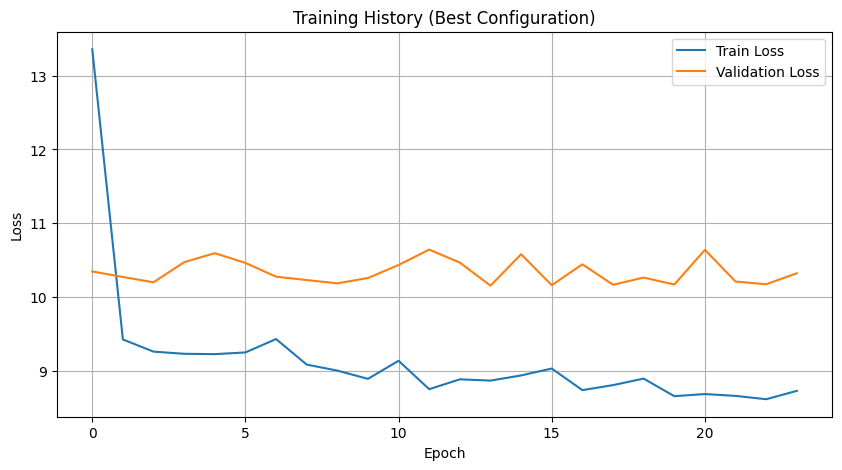


Best model saved at epoch 14 with validation loss 10.1526


In [128]:
# Train final model with best configuration found from search
final_model = ParameterPredictor(best_config)
lossfcn = nn.MSELoss()

# Extract learning rate from best_config or use default
lr = best_config.get('learning_rate', 0.01)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)

final_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    final_optimizer,
    mode='min',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    #verbose=True
)

# Train for more epochs since this is the final model
final_outputs = train_model(
    final_model, 
    final_optimizer, 
    lossfcn, 
    200,  # More epochs for final training
    train_loader, 
    val_loader, 
    patience=10,  # More patience for final model
    scheduler=final_scheduler,
    save_best_model=True,  # Save the best model checkpoint
    model_path='best_final_model.pt'  # Path to save the model
)

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(final_outputs['train_losses'], label='Train Loss')
plt.plot(final_outputs['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History (Best Configuration)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nBest model saved at epoch {final_outputs['best_val_epoch'] + 1} with validation loss {final_outputs['best_val_loss']:.4f}")

# Evaluation

In [129]:
# Load the best saved model for evaluation
eval_model, checkpoint = load_best_model('best_final_model.pt')

# Display the configuration of the loaded model
print("\nModel Configuration:")
for key, value in checkpoint['model_config'].items():
    print(f"  {key}: {value}")

Loaded model from best_final_model.pt
  Best epoch: 14
  Best validation loss: 10.1526

Model Configuration:
  input_size: 1
  lstm_hidden_size: 128
  lstm_num_layers: 1
  fc_layer_sizes: [128, 64]
  activation: relu
  dropout: 0.0
  learning_rate: 0.01


Test Set Performance (Best Saved Model):
  RMSE: 2.9447
  MAE: 2.4055
  R²: -0.0204


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

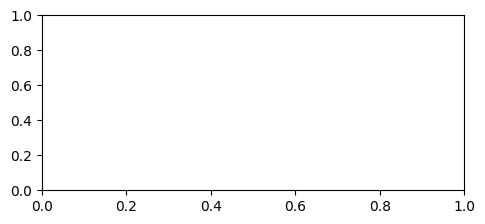

In [137]:
predictions = []
labels = []
rmse_list = []

# Use eval_model (loaded from checkpoint)
eval_model.eval()

for X_test, y_test in test_loader:
    test_predictions = eval_model(X_test).detach().numpy() # test_predictions = eval_model(X_test).detach().numpy()
    test_targets = y_test.numpy()
    predictions.extend(test_predictions)
    labels.extend(test_targets)
    rmse = np.sqrt(np.mean((test_predictions - test_targets) ** 2))
    rmse_list.append(rmse)
    
predictions = np.array(predictions)
labels = np.array(labels)

# Calculate overall test metrics
test_metrics = calculate_metrics(np.array(predictions), np.array(labels))

print("Test Set Performance (Best Saved Model):")
print(f"  RMSE: {test_metrics['rmse']:.4f}")
print(f"  MAE: {test_metrics['mae']:.4f}")
print(f"  R²: {test_metrics['r2']:.4f}")

# Plot prediction vs true distribution
plt.figure(figsize=(12, 5))
'''
plt.subplot(1, 2, 1)
l_counts, l_edges = np.histogram(labels, bins=30, density=True)
p_counts, p_edges = np.histogram(predictions, bins=l_edges, density=True)  # align bins with predictions
plt.stairs(p_counts, p_edges, label='Predictions', color='C0')
plt.stairs(l_counts, l_edges, label='True Labels', color='C1')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot scatter: predictions vs true values
plt.subplot(1, 2, 2)
plt.scatter(labels, predictions, alpha=0.5)
plt.plot([min(labels), max(labels)], [min(labels), max(labels)], 'r--', label='Perfect prediction')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values (R²={test_metrics["r2"]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
'''

for i, name in enumerate(['amplitude', 'frequency', ]):
    plt.subplot(2, 2, 1 + i)
    plt.hist(labels[:, i], bins=30, density=True, alpha=0.6, label='True')
    plt.hist(predictions[:, i], bins=30, density=True, alpha=0.6, label='Predicted')
    plt.title(f'Distribution - {name}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3 + i)
    plt.scatter(labels[:, i], predictions[:, i], alpha=0.5)
    vmin = min(labels[:, i].min(), predictions[:, i].min())
    vmax = max(labels[:, i].max(), predictions[:, i].max())
    plt.plot([vmin, vmax], [vmin, vmax], 'r--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'Pred vs True - {name}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


random pycbc stuff

In [ ]:
# from pycbc.waveform import get_td_waveform

# hp, hc = get_td_waveform(approximant="IMRPhenomD", mass1=10,mass2=10,spin1z=0.9,delta_t=1/4096,f_lower=40)

# print(hp.sample_times)

Explanation by copilot, I am using too much ai :(

    LSTM — short summary

LSTM (Long Short‑Term Memory) is a recurrent neural unit designed to learn long‑range dependencies in sequences.
Core components: cell state (long‑term memory) and three gates — input (what to write), forget (what to drop), output (what to expose).
Gates are learned multiplicative filters (sigmoid activations) that control information flow, which prevents vanishing/exploding gradients for long sequences.
How the notebook uses an LSTM (concise mapping to your code)

Input shape: X comes in as [batch, seq_len] and the model does x = x.unsqueeze(-1) → [batch, seq_len, 1] so feature_dim=1 per timestep.
LSTM instantiation: nn.LSTM(input_size=1, hidden_size=..., num_layers=...) — this processes the time series and produces outputs at every timestep plus hidden/cell states.
last_out = lstm_out[:, -1, :] — the code takes the last timestep's LSTM output (a fixed-length vector summarising the sequence) and feeds it to a small fully connected head that outputs a single scalar parameter.
Training target: regression (MSE) to the scalar parameter (amplitude).
Is an LSTM the best approach for pulling out a single parameter?
Short answer: not necessarily — it depends on the problem, noise, waveform knowledge, and compute/data budget.

When LSTM is appropriate

Temporal ordering matters and the parameter depends on long‑range time relationships in a way that simple summary stats can't capture.
You have enough labelled training examples to learn those dependencies.
You want a learned, flexible sequence encoder that can handle variable‑length inputs (with care).
When something else is often better

If the goal is to extract a single global parameter (e.g., amplitude, phase, frequency) from a known deterministic signal in noise, classical signal processing or matched filtering is usually superior (optimal in Gaussian noise, efficient, and interpretable).
If you only need a robust scalar estimate and not to reproduce or model the waveform, much simpler/faster options work well:
Summary statistics (mean, variance), peaks in Fourier/periodogram, envelope detection.
Matched filtering / template fitting (especially for gravitational‑wave style waveforms).
1D CNN + global pooling (faster to train than LSTM, good at local patterns and translational invariance).
Linear / kernel regression on engineered features (FFT magnitudes, wavelet coefficients).
If you want uncertainty or a posterior

LSTM + deterministic head gives point estimates only. For uncertainties / posteriors:
Predict mean and log‑variance and train with Gaussian NLL loss.
Use MC dropout or deep ensembles for approximate uncertainty.
Use probabilistic models / normalizing flows / amortized inference for full posterior estimates (dingo, conditional density estimators).
Practical improvements you can make if you keep LSTM

Normalize input sequences (zero mean, unit variance per sample or dataset).
Downsample or window the sequence to shorten seq_len if signal is smooth.
Use global pooling over timesteps (mean/max) or attention over timesteps instead of only last timestep.
Consider a 1D CNN encoder (fewer parameters, faster) or hybrid CNN→LSTM (CNN extracts local features, LSTM aggregates).
Predict both value and uncertainty (e.g., output mu and log_sigma and train with negative log likelihood).
Recommendation (concise)

If you know the waveform shape and noise approximates Gaussian: use matched filtering or template fitting — best accuracy and interpretability.
If you want a learned estimator and have lots of labelled data: 1D CNN with global pooling or a small encoder + MLP (or CNN+attention) is usually faster and as effective as an LSTM for extracting a single scalar.
If you need uncertainties/posteriors, augment the model to predict variance or use probabilistic/ensemble methods.
If you want, I can:

Show a compact 1D‑CNN regressor example that maps sequence → scalar (faster than LSTM), or
Add uncertainty prediction to your LSTM head (mu, sigma) with Gaussian NLL loss.